In [1]:
import sys
sys.path.insert(0, '../tools')

%load_ext prov_magics
import provn
import prov_dictionary

# PROV Dictionary

## Names, literals, and constants

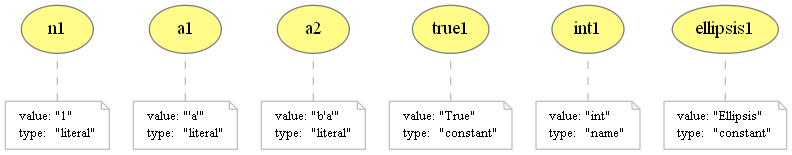

In [2]:
%%provn -o ../prov_dictionary/names -e png svg pdf provn
entity(n1, [value="1", type="literal"])
entity(a1, [value="'a'", type="literal"])
entity(a2, [value="b'a'", type="literal"])
entity(true1, [prov:value="True", type="constant"])
entity(int1, [prov:value="int", type="name"])
entity(ellipsis1, [prov:value="Ellipsis", type="constant"])

## Assignment

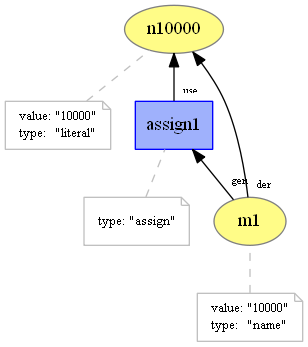

In [3]:
%%provn -o ../prov_dictionary/assign -e png svg pdf provn
entity(n10000, [value="10000", type="literal"])
entity(m1, [value="10000", type="name"])

activity(assign1, [type="assign"])
used(u1; assign1, n10000, -)
wasGeneratedBy(g1; m1, assign1, -)
wasDerivedFrom(m1, n10000, assign1, g1, u1)

## Operation

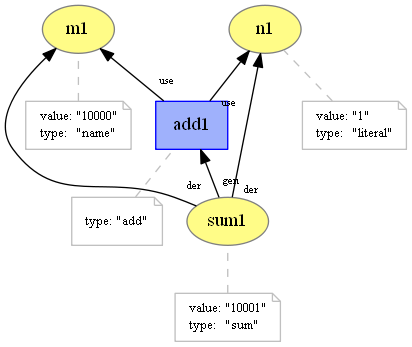

In [4]:
%%provn -o ../prov_dictionary/operation -e png svg pdf provn
entity(m1, [value="10000", type="name"])
entity(n1, [value="1", type="literal"])
entity(sum1, [value="10001", type="sum"])

activity(add1, [type="add"])
used(u2; add1, m1, -)
used(u3; add1, n1, -)
wasGeneratedBy(g2; sum1, add1, -)
wasDerivedFrom(sum1, m1, add1, g2, u2)
wasDerivedFrom(sum1, n1, add1, g3, u3)

## List definition

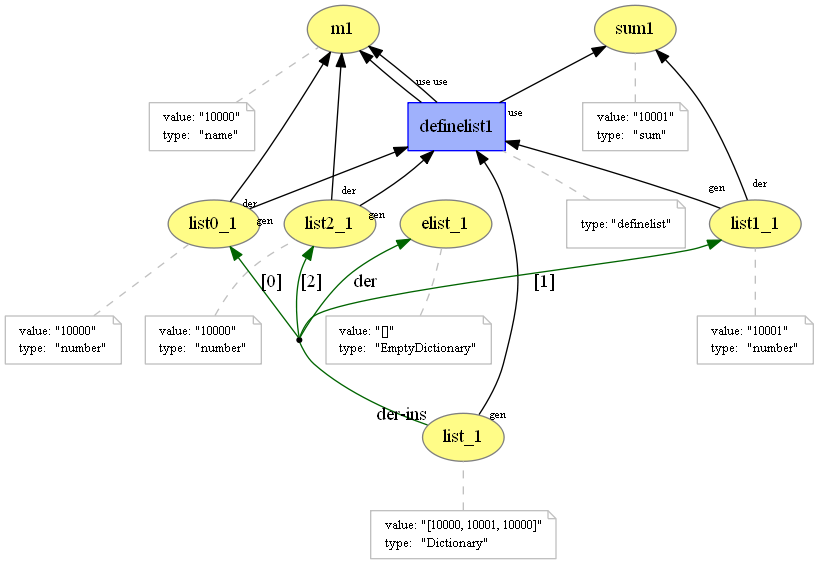

In [5]:
%%provn -o ../prov_dictionary/list -e png svg pdf provn
entity(m1, [value="10000", type="name"])
entity(sum1, [value="10001", type="sum"])

entity(elist_1, [value="[]", type="EmptyDictionary"])
entity(list_1, [value="[10000, 10001, 10000]", type="Dictionary"])
entity(list0_1, [value="10000", type="number"])
entity(list1_1, [value="10001", type="number"])
entity(list2_1, [value="10000", type="number"])
derivedByInsertionFrom(
    list_1, elist_1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

activity(definelist1, [type="definelist"])
used(u4; definelist1, m1, -)
wasGeneratedBy(g4; list0_1, definelist1, -)
wasDerivedFrom(list0_1, m1, definelist1, g4, u4)
used(u5; definelist1, sum1, -)
wasGeneratedBy(g5; list1_1, definelist1, -)
wasDerivedFrom(list1_1, sum1, definelist1, g5, u5)
used(u6; definelist1, m1, -)
wasGeneratedBy(g6; list2_1, definelist1, -)
wasDerivedFrom(list2_1, m1, definelist1, g6, u6)
wasGeneratedBy(list_1, definelist1, -)

## Assignment of list definition

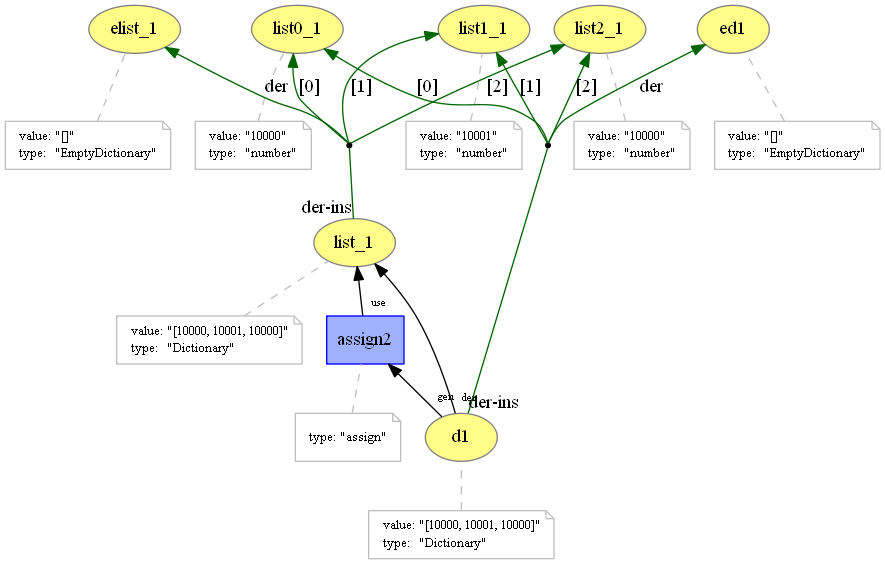

In [6]:
%%provn -o ../prov_dictionary/list_assign -e png svg pdf provn
// old entities from previous figure
entity(elist_1, [value="[]", type="EmptyDictionary"])
entity(list_1, [value="[10000, 10001, 10000]", type="Dictionary"])
entity(list0_1, [value="10000", type="number"])
entity(list1_1, [value="10001", type="number"])
entity(list2_1, [value="10000", type="number"])
derivedByInsertionFrom(
    list_1, elist_1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

// new entities
entity(ed1, [value="[]", type="EmptyDictionary"])
entity(d1, [value="[10000, 10001, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    d1, ed1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

activity(assign2, [type="assign"])
used(u7; assign2, list_1, -)
wasGeneratedBy(g7; d1, assign2, -)
wasDerivedFrom(d1, list_1, assign2, g7, u7)

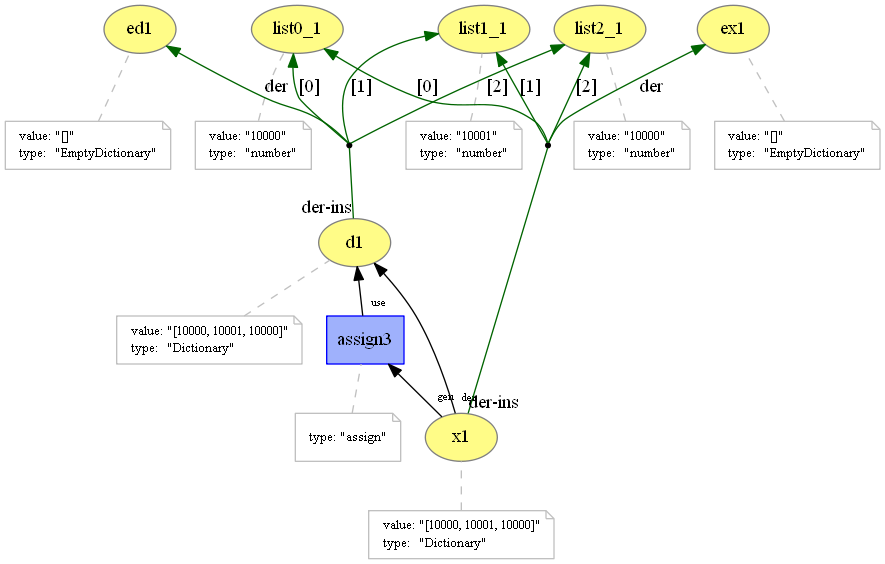

In [7]:
%%provn -o ../prov_dictionary/list_assign2 -e png svg pdf provn
// old entities from previous figure
entity(ed1, [value="[]", type="EmptyDictionary"])
entity(d1, [value="[10000, 10001, 10000]", type="Dictionary"])
entity(list0_1, [value="10000", type="number"])
entity(list1_1, [value="10001", type="number"])
entity(list2_1, [value="10000", type="number"])
derivedByInsertionFrom(
    d1, ed1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

// new entities
entity(ex1, [value="[]", type="EmptyDictionary"])
entity(x1, [value="[10000, 10001, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    x1, ex1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

activity(assign3, [type="assign"])
used(u8; assign3, d1, -)
wasGeneratedBy(g8; x1, assign3, -)
wasDerivedFrom(x1, d1, assign3, g8, u8)

## Function call

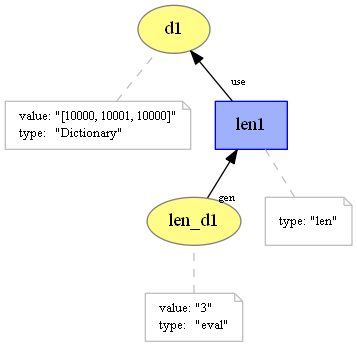

In [8]:
%%provn -o ../prov_dictionary/call -e png svg pdf provn
entity(d1, [value="[10000, 10001, 10000]", type="Dictionary"])
entity(len_d1, [value="3", type="eval"])

activity(len1, [type="len"])
used(len1, d1, -)
wasGeneratedBy(len_d1, len1, -)

## Access to part of structure

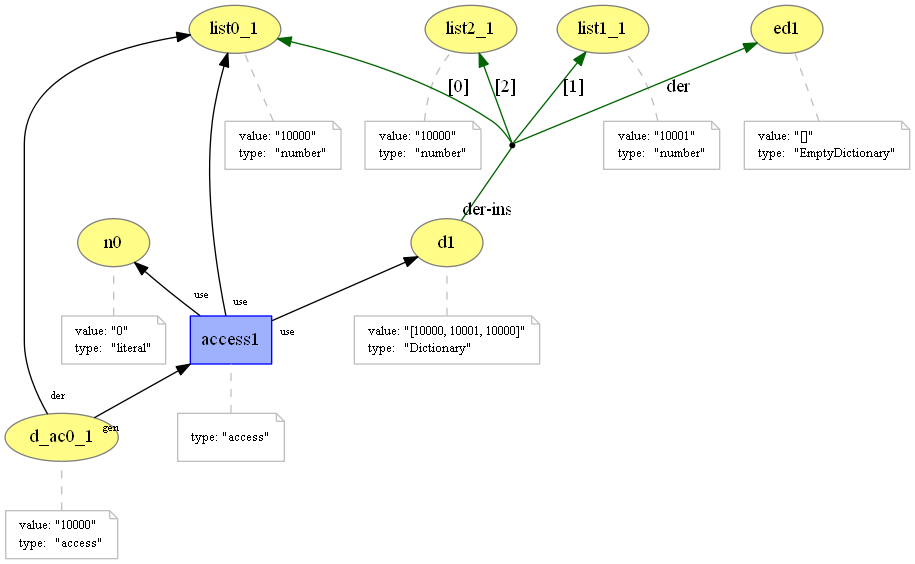

In [9]:
%%provn -o ../prov_dictionary/access -e png svg pdf provn
//previous
entity(list0_1, [value="10000", type="number"])
entity(list1_1, [value="10001", type="number"])
entity(list2_1, [value="10000", type="number"])
entity(ed1, [value="[]", type="EmptyDictionary"])
entity(d1, [value="[10000, 10001, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    d1, ed1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)


//access
entity(n0, [value="0", type="literal"])
entity(d_ac0_1, [value="10000", type="access"])

activity(access1, [type="access"])
used(access1, d1, -)
used(access1, n0, -)
used(u9; access1, list0_1, -)
wasGeneratedBy(g9; d_ac0_1, access1, -)
wasDerivedFrom(d_ac0_1, list0_1, access1, g9, u9)

## Assignment to part of structure

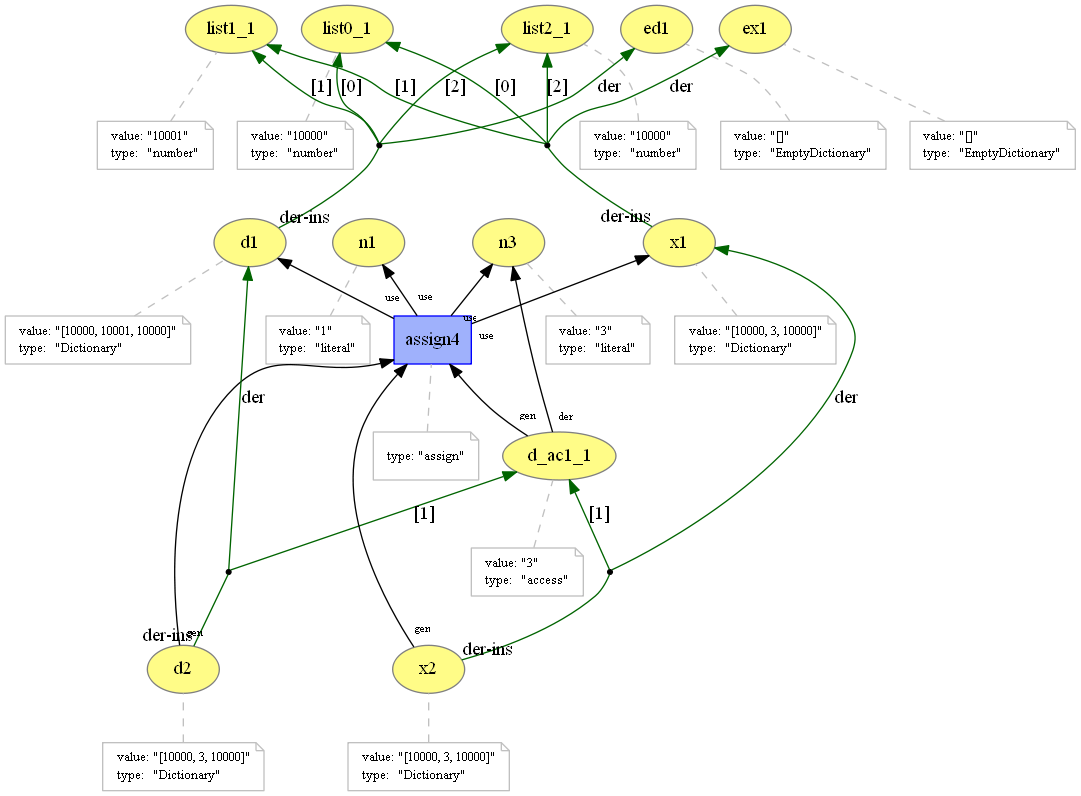

In [10]:
%%provn -o ../prov_dictionary/part_assign -e png svg pdf provn
//previous
entity(list0_1, [value="10000", type="number"])
entity(list1_1, [value="10001", type="number"])
entity(list2_1, [value="10000", type="number"])
entity(ed1, [value="[]", type="EmptyDictionary"])
entity(d1, [value="[10000, 10001, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    d1, ed1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

entity(ex1, [value="[]", type="EmptyDictionary"])
entity(x1, [value="[10000, 3, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    x1, ex1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

//part assign
entity(n1, [value="1", type="literal"])
entity(n3, [value="3", type="literal"])
entity(d_ac1_1, [value="3", type="access"])
entity(d2, [value="[10000, 3, 10000]", type="Dictionary"])
derivedByInsertionFrom(d2, d1, {("1", d_ac1_1)})
entity(x2, [value="[10000, 3, 10000]", type="Dictionary"])
derivedByInsertionFrom(x2, x1, {("1", d_ac1_1)})

activity(assign4, [type="assign"])
used(assign4, d1, -)
used(assign4, x1, -)
used(assign4, n1, -)
used(u10; assign4, n3, -)
wasGeneratedBy(g10; d_ac1_1, assign4, -)
wasGeneratedBy(d2, assign4, -)
wasGeneratedBy(x2, assign4, -)
wasDerivedFrom(d_ac1_1, n3, assign4, g10, u10)

## Full

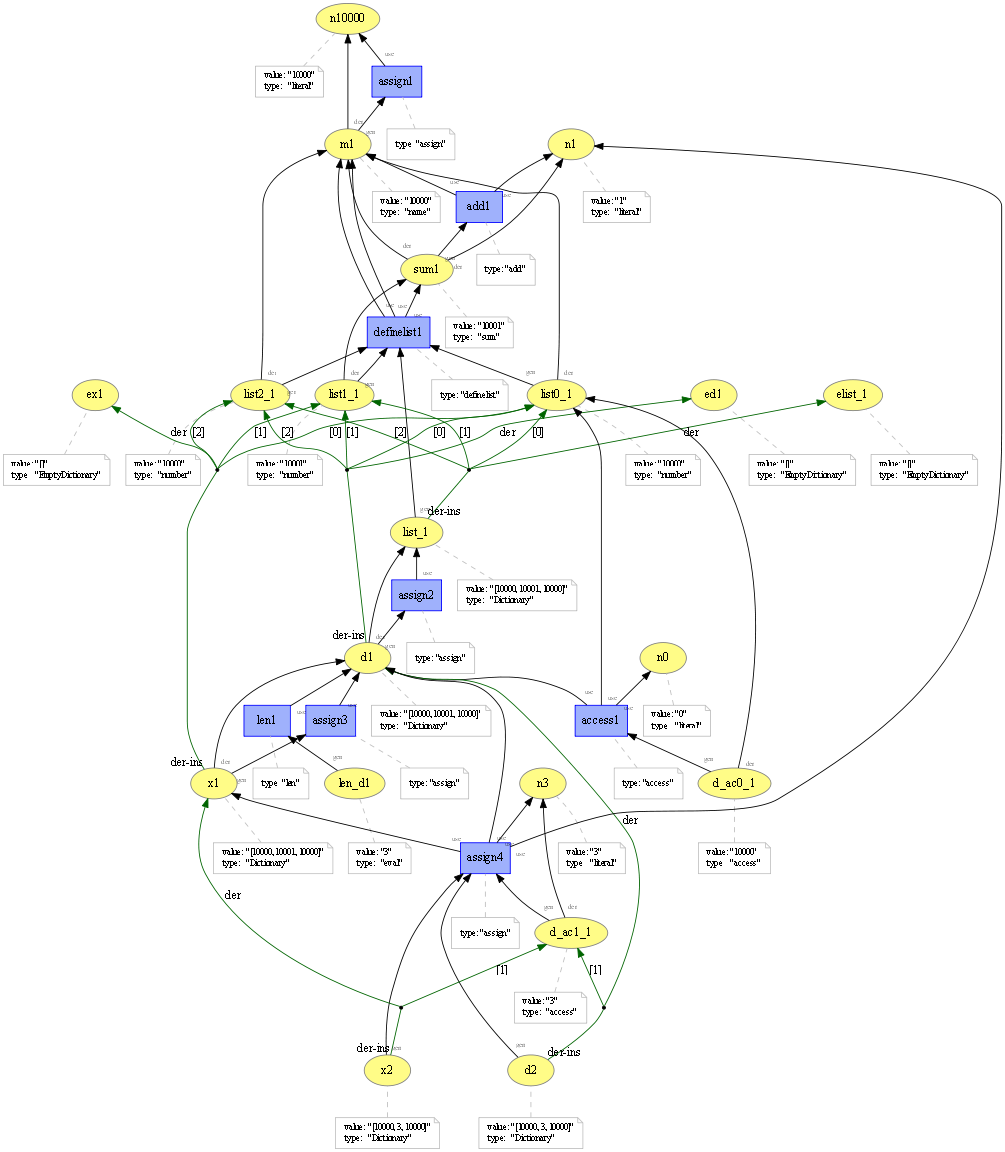

In [12]:
%%provn -o ../prov_dictionary/full -e png svg pdf provn
// assignment
entity(n10000, [value="10000", type="literal"])
entity(m1, [value="10000", type="name"])

activity(assign1, [type="assign"])
used(u1; assign1, n10000, -)
wasGeneratedBy(g1; m1, assign1, -)
wasDerivedFrom(m1, n10000, assign1, g1, u1)

// operation
entity(n1, [value="1", type="literal"])
entity(sum1, [value="10001", type="sum"])

activity(add1, [type="add"])
used(u2; add1, m1, -)
used(u3; add1, n1, -)
wasGeneratedBy(g2; sum1, add1, -)
wasDerivedFrom(sum1, m1, add1, g2, u2)
wasDerivedFrom(sum1, n1, add1, g3, u3)

// list definition
entity(elist_1, [value="[]", type="EmptyDictionary"])
entity(list_1, [value="[10000, 10001, 10000]", type="Dictionary"])
entity(list0_1, [value="10000", type="number"])
entity(list1_1, [value="10001", type="number"])
entity(list2_1, [value="10000", type="number"])
derivedByInsertionFrom(
    list_1, elist_1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

activity(definelist1, [type="definelist"])
used(u4; definelist1, m1, -)
wasGeneratedBy(g4; list0_1, definelist1, -)
wasDerivedFrom(list0_1, m1, definelist1, g4, u4)
used(u5; definelist1, sum1, -)
wasGeneratedBy(g5; list1_1, definelist1, -)
wasDerivedFrom(list1_1, sum1, definelist1, g5, u5)
used(u6; definelist1, m1, -)
wasGeneratedBy(g6; list2_1, definelist1, -)
wasDerivedFrom(list2_1, m1, definelist1, g6, u6)
wasGeneratedBy(list_1, definelist1, -)

// list assignment
entity(ed1, [value="[]", type="EmptyDictionary"])
entity(d1, [value="[10000, 10001, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    d1, ed1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

activity(assign2, [type="assign"])
used(u7; assign2, list_1, -)
wasGeneratedBy(g7; d1, assign2, -)
wasDerivedFrom(d1, list_1, assign2, g7, u7)

// list assignment 2
entity(ex1, [value="[]", type="EmptyDictionary"])
entity(x1, [value="[10000, 10001, 10000]", type="Dictionary"])
derivedByInsertionFrom(
    x1, ex1,
    {("0", list0_1), ("1", list1_1), ("2", list2_1)}
)

activity(assign3, [type="assign"])
used(u8; assign3, d1, -)
wasGeneratedBy(g8; x1, assign3, -)
wasDerivedFrom(x1, d1, assign3, g8, u8)

// call
entity(len_d1, [value="3", type="eval"])

activity(len1, [type="len"])
used(len1, d1, -)
wasGeneratedBy(len_d1, len1, -)

// part access
entity(n0, [value="0", type="literal"])
entity(d_ac0_1, [value="10000", type="access"])

activity(access1, [type="access"])
used(access1, d1, -)
used(access1, n0, -)
used(u9; access1, list0_1, -)
wasGeneratedBy(g9; d_ac0_1, access1, -)
wasDerivedFrom(d_ac0_1, list0_1, access1, g9, u9)

// part assignment
entity(n3, [value="3", type="literal"])
entity(d_ac1_1, [value="3", type="access"])
entity(d2, [value="[10000, 3, 10000]", type="Dictionary"])
derivedByInsertionFrom(d2, d1, {("1", d_ac1_1)})
entity(x2, [value="[10000, 3, 10000]", type="Dictionary"])
derivedByInsertionFrom(x2, x1, {("1", d_ac1_1)})

activity(assign4, [type="assign"])
used(assign4, d1, -)
used(assign4, x1, -)
used(assign4, n1, -)
used(u10; assign4, n3, -)
wasGeneratedBy(g10; d_ac1_1, assign4, -)
wasGeneratedBy(d2, assign4, -)
wasGeneratedBy(x2, assign4, -)
wasDerivedFrom(d_ac1_1, n3, assign4, g10, u10)
